# Notebook 05 - Modelling and Evaluation

## Objectives

* Fit and evaluate a classification model that predicts whether or not an existing customer will default in the following month

## Inputs

* Data Cleaning pipeline
* Feature Engineering pipeline

## Outputs

* Combined data cleaning and feature engineering pipeline
* Pipeline for modelling and hyperparameter optimisation
* [xxx]

## Additional Comments

* We already have separate pipelines for data cleaning and feature engineering. However, for ease of use on future datasets, these can be combined into a single pipeline

---

# Change working directory

* This notebook is stored in the `jupyter_notebooks` subfolder
* The current working directory therefore needs to be changed to the workspace, i.e., the working directory needs to be changed from the current folder to its parent folder

Firstly, the current directory is accessed with os.getcwd()

In [98]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\franc\\credit-card-default'

Next, the working directory is set as the parent of the current `jupyter_notebooks` directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory
* This allows access to all the files and folders within the workspace, rather than solely those within the `jupyter_notebooks` directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Finally, confirm that the new current directory has been successfully set

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\franc\\credit-card-default'

---

# Load data

The data is loaded from the outputs/datasets/collection folder:

In [114]:
import pandas as pd
df = pd.read_csv('outputs/datasets/collection/credit_card_data.csv')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


---

# ML pipeline for data cleaning and feature engineering

Here our existing data cleaning and feature engineering pipelines are combined into a single pipeline:

In [115]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from feature_engine.selection import DropFeatures
from feature_engine.encoding import OneHotEncoder


def rename_columns(X):
    X.columns = ['credit_limit', 'sex', 'education', 'marital_status',
                 'age', 'late_sep', 'late_aug', 'late_jul', 'late_jun',
                 'late_may', 'late_apr', 'bill_sep', 'bill_aug',
                 'bill_jul', 'bill_jun', 'bill_may', 'bill_apr',
                 'prev_payment_sep', 'prev_payment_aug',
                 'prev_payment_jul', 'prev_payment_jun',
                 'prev_payment_may', 'prev_payment_apr',
                 'default_next_month']
    return X


def clean_categorical_data(X):
    sex_mapping = {1: "male", 2: "female"}
    education_mapping = {1: "graduate school", 2: "university", 3: "high school", 4: "other", 5: "unknown", 6: "unknown"}
    marital_status_mapping = {0: "unknown", 1: "married", 2: "single", 3: "other"}
    X['sex'] = X['sex'].replace(sex_mapping)
    X['education'] = X['education'].replace(education_mapping)
    X['marital_status'] = X['marital_status'].replace(marital_status_mapping)
    return X


def default_summary(X):
    X['any_default'] = X[['late_sep', 'late_aug', 'late_jul', 'late_jun',
                 'late_may', 'late_apr']].gt(0).any(axis=1).astype(int)
    X['total_default'] = X[['late_sep', 'late_aug', 'late_jul', 'late_jun',
                 'late_may', 'late_apr']].clip(lower=0).sum(axis=1)
    X['greatest_default'] = X[['late_sep', 'late_aug', 'late_jul', 'late_jun',
                 'late_may', 'late_apr']].clip(lower=0).max(axis=1)
    return X


def ordinal_encode_education(X):
    X['education'] = X['education'].map(education_map)
    X['education'] = X['education'].fillna(0)
    return X

variables_ohe = ['sex', 'marital_status']

education_map = {
    '0': 0,
    'other': 0,
    'unknown': 0,
    'high school': 1,
    'university': 2,
    'graduate school': 3
}

data_cleaning_and_feature_engineering_pipeline = Pipeline([
      ('drop',  DropFeatures(features_to_drop=['ID'])),
      ('rename_columns', FunctionTransformer(rename_columns, validate=False)),
      ('clean_categorical_data', FunctionTransformer(clean_categorical_data)),
      ('add_default_summary', FunctionTransformer(default_summary)),
      ('one_hot_encode', OneHotEncoder(variables=variables_ohe, drop_last=True)),
      ('ordinal_encode', FunctionTransformer(ordinal_encode_education)),
      ('drop_after_cleaning',  DropFeatures(features_to_drop=['late_sep', 'late_aug', 'late_jun',
                                               'late_may', 'late_apr', 'bill_aug', 
                                               'bill_jul', 'bill_jun', 'bill_may', 
                                               'bill_apr', 'any_default', 'greatest_default',
                                               'marital_status_married'])),
])

---

# ML Pipeline for Modelling and Hyperparameter Optimisation

In [116]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier


def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

Custom Class for Hyperparameter Optimisation, taken from CI's WP02:

In [117]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches


---

# Prepare Data for Modelling

## Apply data cleaning and feature engineering pipeline

Since the feature engineering processes for this dataset cannot introduce any bias or data leakage, it is possible (and requires less code) to apply the data cleaning and feature engineering pipeline to the entire dataframe before splitting it into test and train sets:

In [118]:
df = data_cleaning_and_feature_engineering_pipeline.fit_transform(df)
df.head()

,credit_limit,education,age,late_jul,bill_sep,prev_payment_sep,prev_payment_aug,prev_payment_jul,prev_payment_jun,prev_payment_may,prev_payment_apr,default_next_month,total_default,sex_female,marital_status_single,marital_status_other
0,20000.0,2.0,24,-1,3913.0,0.0,689.0,0.0,0.0,0.0,0.0,1,4,1,0,0
1,120000.0,2.0,26,0,2682.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1,4,1,1,0
2,90000.0,2.0,34,0,29239.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,0,1,1,0
3,50000.0,2.0,37,0,46990.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,0,1,0,0
4,50000.0,2.0,57,-1,8617.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0,0,0,0,0


## Split data into train and test set

Split train and test set. Note that by keeping `random_state` the same value as in the previous notebook, we can be sure to split the data in exactly the same way.
* We inspect the shape of each of `X_train`, `y_train`, `X_test` and `y_test` as a check that the split has worked correctly

In [119]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['default_next_month'], axis=1),
    df['default_next_month'],
    test_size=0.2,
    random_state=42,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(24000, 15) (24000,) (6000, 15) (6000,)


In [120]:
y_train.head()

21753    0
251      0
22941    0
618      0
17090    0
Name: default_next_month, dtype: int64

## Handle Target Imbalance

First, we check the distribution of the train set target:

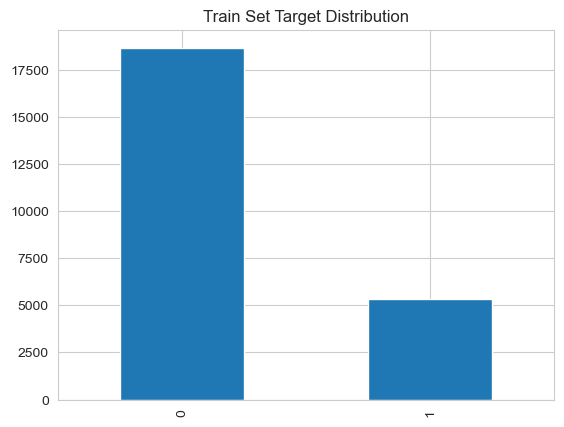

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

We can clearly see that the dataset is imbalanced. To address this, we can either:
* oversample the minority examples to create synthetic examples of the minority class, or
* undersample the majority examples to remove some of the observations that fall into that class.

Both oversampling and undersampling have advantages and disadvantages:
* Oversampling does not decrease the size of the dataset and does not lose any of the information present in the dataset. However, it can increase the chance of overfitting the model, since it increases the presence of characteristics in the dataset that were initially only applicable to a relatively small number of observations
* Undersampling has the advantage that it does not introduce further information into the dataset and create this risk of overfitting. However, it does reduce the size of the dataset and by definition will lose some information.

In this case, the size of the dataset is not excessive and so we will attempt oversampling; however, if we observe that the model is overfitting, we can try undersampling instead.

### Use SMOTE to balance the Train Set target

SMOTE, or Synthetic Minority Oversampling TEchnique, works by selecting examples from the minority class that are close to one another in the feature space, and creating a new sample at a point between these samples.
* "Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space" - [Machine Learning Mastery](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

In [122]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(37354, 15) (37354,) (6000, 15) (6000,)


Finally, we check the train set target distribution again after oversampling. An equal distribution is now seen:

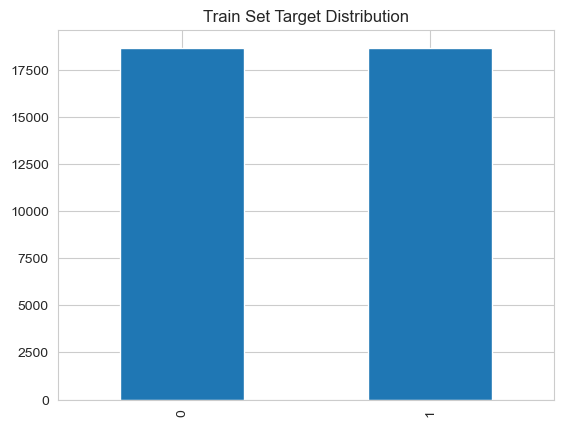

In [123]:
import matplotlib.pyplot as plt
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

---

# Train the ML pipeline to predict default in the following month

## Find the most suitable algorithm for the data

First, we want to test multiple algorithms using their default hyperparameters, in order to find the algorithm(s) that best suit the data.
* Note that in the `models_quick_search` dictionary, the Bernoulli Naive Bayes classifier does not have the `random_state` parameter set to 0 because Bayesian classifiers do not involve any randomisation or stochastic processes during training or prediction; as such, they do not need the `random_state` parameter to be set to ensure reproducibility, whereas the other classifier models do have this requirement
* Note that using the empty dictionaries within the `params_quick_search` dictionary means that the default hyperparameter values will be used

In [124]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
    "BernoulliNBClassifier": BernoulliNB(),
    "LinearSVCClassifier": LinearSVC(random_state=0)
}

params_quick_search = {
    "LogisticRegression": {},
    "XGBClassifier": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "GradientBoostingClassifier": {},
    "ExtraTreesClassifier": {},
    "AdaBoostClassifier": {},
    "BernoulliNBClassifier": {},
    "LinearSVCClassifier": {}
}


We now run GridSearch CV to identify the best performing algorithms for the data:

In [179]:
from sklearn.metrics import make_scorer, f1_score
f1_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
f1_search.fit(X_train, y_train,
           scoring =  make_scorer(f1_score),
           n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for BernoulliNBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\franc\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)



Running GridSearchCV for LinearSVCClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\franc\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\Users\franc\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Now we can check the results:

In [180]:
import numpy as np
f1_grid_search_summary, grid_search_pipelines = f1_search.score_summary(sort_by='mean_score')
f1_grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
5,ExtraTreesClassifier,0.595329,0.803749,0.8815,0.11058
3,RandomForestClassifier,0.533874,0.802016,0.893748,0.138274
1,XGBClassifier,0.505076,0.764225,0.860878,0.135526
4,GradientBoostingClassifier,0.572544,0.762395,0.832596,0.099387
6,AdaBoostClassifier,0.595829,0.74434,0.823684,0.081568
2,DecisionTreeClassifier,0.532465,0.736858,0.824809,0.111681
0,LogisticRegression,0.595441,0.694299,0.734864,0.051953
8,LinearSVCClassifier,0.584422,0.690675,0.730998,0.055158
7,BernoulliNBClassifier,0.637851,0.652505,0.659104,0.007927


## Hyperparameter optimisation for selected algorithms

We will consider `ExtraTreesClassifier` and `RandomForestClassifier`, since these have the highest mean scores, both scoring 0.80, before a significant dropoff to `XGBClassifier`	with 0.76.

`ExtraTreesClassifier` and `RandomForestClassifier` are both bagging ensemble methods.
* The [sklearn documentation](https://scikit-learn.org/stable/modules/ensemble.html) notes that some important parameters to adjust when using these methods are `n_estimators` and `max_features`.
* In addition to these, a number of other hyperparameters are also explored, as follows:
* `n_estimators` is the number of trees in the forest. The larger the better, but also the longer it will take to compute. In addition, note that results will stop getting significantly better beyond a critical number of trees.
    - The values of 50, 100 and 140 are assessed for `RandomForestClassifier` and 50, 100 and 150 for `ExtraTreesClassifier`.
    - These values have been selected to explore different ensemble sizes.
* `max_features` is the size of the random subsets of features to consider when splitting a node to find the best split. The lower this value the greater the reduction of variance, but also the greater the increase in bias.
    - For both algorithms, the values of `sqrt`, `log2` and `None` are assessed, corresponding respectively to the square root of the total number of features, to the base-2 logarithm, and to considering all features.
    - Considering different values allows for the evaluation of varying feature subsets during tree construction.
* `max_depth` is the maximum depth allowed for each decision tree. As noted in the [sklearn docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html), if this is set to None, then nodes are expanded until all leaves are pure or until all leaves contain less than `min_samples_split` samples.
    - Here, values of None, 4, and 15 are evaluated for `RandomForestClassifier` and None, 3 and 15 for `ExtraTreesClassifier`.
    - This allows us to investigate different levels of tree complexity.
    -  A deeper tree can capture more intricate patterns but may also overfit.
* `min_samples_split` is the minimum number of samples required to split an internal node.
    - Values of 2, 25, and 50 are considered for both algorithms, representing a range of different thresholds for node splitting.
    - Smaller values can lead to more flexible trees, but also increase the risk of overfitting.
* `min_samples_leaf` is the minimum number of samples required to be at a leaf node. That is, a split point at any depth will only be considered if it leaves at least `min_samples_leaf` training samples in each of the left and right branches.
    - With values of 1, 25, and 50 assessed for both algorithms, different leaf node sizes are explored.
    - Larger values can prevent overfitting, but could also result in underfitting.
* `max_leaf_nodes` is the maximum number of nodes allowed in each decision tree.
    - For both algorithms, values of None, 25 and 50 are considered.
    - Setting None allows for unlimited leaf nodes, while specifying a value can limit the complexity of the tree.

First, we will define the models and parameters for the extensive search.

In [183]:
models_search = {
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
}

params_search = {
    "RandomForestClassifier": {
        'model__n_estimators': [50, 100, 140],
        'model__max_depth': [None, 4, 15],
        'model__min_samples_split': [2, 25, 50],
        'model__min_samples_leaf': [1, 25, 50],
        'model__max_leaf_nodes': [None, 25, 50],
        'model__max_features': ['sqrt', 'log2', None]
    },
    "ExtraTreesClassifier": {
        'model__n_estimators': [50, 100, 150],
        'model__max_depth': [None, 3, 15],
        'model__min_samples_split': [2, 25, 50],
        'model__min_samples_leaf': [1, 25, 50],
        'model__max_leaf_nodes': [None, 25, 50],
        'model__max_features': ['sqrt', 'log2', None]
    }
}


In [184]:
detail_search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
detail_search.fit(X_train, y_train,
           scoring =  make_scorer(f1_score),
           n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 729 candidates, totalling 3645 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


Now we can check the results to see which combination of algorithm and hyperparameters produced the highest mean score:

In [198]:
grid_search_summary, grid_search_pipelines = detail_search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
812,ExtraTreesClassifier,0.595622,0.804249,0.882105,0.110766,None,log2,None,1,2,150
731,ExtraTreesClassifier,0.595622,0.804249,0.882105,0.110766,None,sqrt,None,1,2,150
811,ExtraTreesClassifier,0.595329,0.803749,0.8815,0.11058,None,log2,None,1,2,100
730,ExtraTreesClassifier,0.595329,0.803749,0.8815,0.11058,None,sqrt,None,1,2,100
2,RandomForestClassifier,0.53424,0.80305,0.894391,0.138641,None,sqrt,None,1,2,140
...,...,...,...,...,...,...,...,...,...,...,...
972,ExtraTreesClassifier,0.645052,0.686062,0.709668,0.021876,3,sqrt,None,1,2,50
1058,ExtraTreesClassifier,0.635055,0.685283,0.713904,0.026793,3,log2,None,1,25,150
977,ExtraTreesClassifier,0.635055,0.685283,0.713904,0.026793,3,sqrt,None,1,25,150
1061,ExtraTreesClassifier,0.633772,0.683574,0.711481,0.026455,3,log2,None,1,50,150


The name of the best model can be extracted from the grid search summary as follows:

In [186]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesClassifier'

The best hyperparameters can also be shown:

In [187]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': None,
 'model__max_features': 'sqrt',
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 150}

As well as the pipeline that contains the best algorithm:

In [188]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesClassifier(random_state=0))),
                ('model',
                 ExtraTreesClassifier(max_features='sqrt', n_estimators=150,
                                      random_state=0))])

In [189]:
X_train.head()

,credit_limit,education,age,late_jul,bill_sep,prev_payment_sep,prev_payment_aug,prev_payment_jul,prev_payment_jun,prev_payment_may,prev_payment_apr,total_default,sex_female,marital_status_single,marital_status_other
0,80000.0,2.0,24,0,75125.0,3503.0,5001.0,2092.0,1218.0,1445.0,878.0,0,1,1,0
1,30000.0,2.0,28,0,29242.0,5006.0,1244.0,851.0,955.0,0.0,0.0,0,0,1,0
2,180000.0,0.0,44,-1,20916.0,0.0,850.0,0.0,6881.0,10340.0,182.0,0,1,0,0
3,60000.0,3.0,25,0,58839.0,2018.0,1900.0,2000.0,1500.0,1900.0,2000.0,0,0,1,0
4,130000.0,2.0,25,0,111587.0,4100.0,4200.0,5000.0,5000.0,5000.0,10700.0,0,1,1,0


We now want to identify the most important features in this pipeline.
* First, 'Feature' identifies the columns (features) from the `X_train` dataframe that were selected by the feature selection step in the pipeline and returns them as a Boolean list.
* Because the best model is tree-based, the most important features in the pipeline can then be accessed using the `feature_importances_` method.
    - These features are then ranked in order of importance and displayed in a bar chart.

* These are the 5 most important features in descending order. The model was trained on them: 
['bill_sep', 'education', 'total_default', 'credit_limit', 'age']


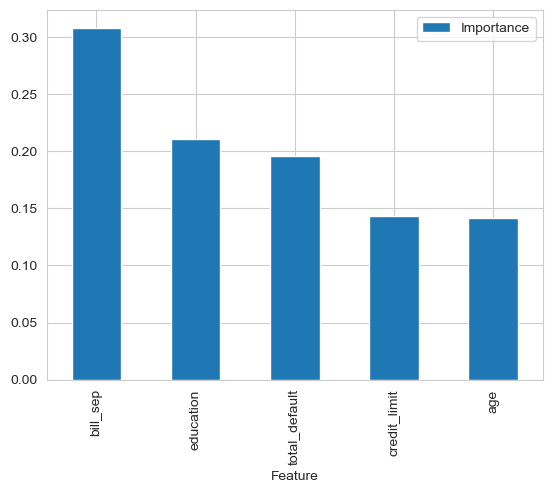

In [191]:
# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': X_train.columns[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# re-assign best_features order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


This is a slightly unexpected set of features, since we did not observe high levels of correlation between the size of the bill or education levels and the target variable.

We can now create a confusion matrix to evaluate the model's performance:

In [192]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)


In [193]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['No Default', 'Default'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                      Actual No Default Actual Default
Prediction No Default             18636            105
Prediction Default                   41          18572


---  Classification Report  ---
              precision    recall  f1-score   support

  No Default       0.99      1.00      1.00     18677
     Default       1.00      0.99      1.00     18677

    accuracy                           1.00     37354
   macro avg       1.00      1.00      1.00     37354
weighted avg       1.00      1.00      1.00     37354
 

#### Test Set ####

---  Confusion Matrix  ---
                      Actual No Default Actual Default
Prediction No Default              3763            699
Prediction Default                  924            614


---  Classification Report  ---
              precision    recall  f1-score   support

  No Default       0.84      0.80      0.82      4687
     Default       0.40      0.47      0.43      1313

    accuracy 

The model's performance on the training data is excellent, with extremely high performance on the test data. The confusion matrix shows very high rates of prediction for both default and no default, and the precision, recall and F1 scores are all close to 1.
* This may already lead us to suspect that the model is overfitting to the training data.

Performance on the test set is very disappointing, with low precision, recall and F1 scores for predicting default. The scores for predicting no default are acceptable, but this is not the metric we are most interested in.
* The model appears to be overfitting to the training data

To address this, we may try adjusting the hyperparameters in a number of ways that will help to reduce the tree's complexity, and hopefully prevent overfitting:
* Reducing the maximum depth (currently set to None)
* Limiting the number of features considered at each split
* Increasing the minimum number of samples required to split a node.

Again, we will define the models and parameters for the extensive search, with the parameters adjusted as described above:


In [194]:
models_search_2 = {
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
}

params_search_2 = {
    "RandomForestClassifier": {
        'model__n_estimators': [140, 200],
        'model__max_depth': [4, 15],
        'model__min_samples_split': [25, 50],
        'model__min_samples_leaf': [25, 50],
        'model__max_leaf_nodes': [25, 50],
        'model__max_features': ['sqrt', 'log2', None]
    },
    "ExtraTreesClassifier": {
        'model__n_estimators': [150, 200],
        'model__max_depth': [3, 15],
        'model__min_samples_split': [25, 50],
        'model__min_samples_leaf': [25, 50],
        'model__max_leaf_nodes': [25, 50],
        'model__max_features': ['sqrt', 'log2', None]
    }
}


Next, conduct the search:

In [195]:
detail_search_2 = HyperparameterOptimizationSearch(models=models_search_2, params=params_search_2)
detail_search_2.fit(X_train, y_train,
           scoring =  make_scorer(f1_score),
           n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 96 candidates, totalling 480 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 96 candidates, totalling 480 fits


Check the results:

In [200]:
grid_search_summary_2, grid_search_pipelines_2 = detail_search_2.score_summary(sort_by='mean_score')
grid_search_summary_2

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
90,RandomForestClassifier,0.579259,0.774903,0.851052,0.10272,15,None,50,25,50,140
88,RandomForestClassifier,0.579259,0.774903,0.851052,0.10272,15,None,50,25,25,140
91,RandomForestClassifier,0.578778,0.77473,0.850602,0.102865,15,None,50,25,50,200
89,RandomForestClassifier,0.578778,0.77473,0.850602,0.102865,15,None,50,25,25,200
95,RandomForestClassifier,0.574366,0.772442,0.848281,0.103665,15,None,50,50,50,200
...,...,...,...,...,...,...,...,...,...,...,...
139,ExtraTreesClassifier,0.668813,0.693628,0.711379,0.014352,3,None,50,25,50,200
141,ExtraTreesClassifier,0.668812,0.693304,0.710881,0.014134,3,None,50,50,25,200
133,ExtraTreesClassifier,0.668812,0.693304,0.710881,0.014134,3,None,25,50,25,200
135,ExtraTreesClassifier,0.668812,0.693304,0.710881,0.014134,3,None,25,50,50,200


Extract the details of the best model:

In [201]:
best_model_2 = grid_search_summary_2.iloc[0,0]
best_model_2

'RandomForestClassifier'

And the best parameters:

In [202]:
best_parameters_2 = grid_search_pipelines_2[best_model_2].best_params_
best_parameters_2

{'model__max_depth': 15,
 'model__max_features': None,
 'model__max_leaf_nodes': 50,
 'model__min_samples_leaf': 25,
 'model__min_samples_split': 25,
 'model__n_estimators': 140}

Retrieve the pipeline that contains the best algorithm:

In [203]:
pipeline_clf_2 = grid_search_pipelines_2[best_model_2].best_estimator_
pipeline_clf_2

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=0))),
                ('model',
                 RandomForestClassifier(max_depth=15, max_features=None,
                                        max_leaf_nodes=50, min_samples_leaf=25,
                                        min_samples_split=25, n_estimators=140,
                                        random_state=0))])

Identify the most important features in the pipeline:

* These are the 5 most important features in descending order. The model was trained on them: 
['total_default', 'education', 'bill_sep', 'credit_limit', 'prev_payment_aug', 'prev_payment_sep']


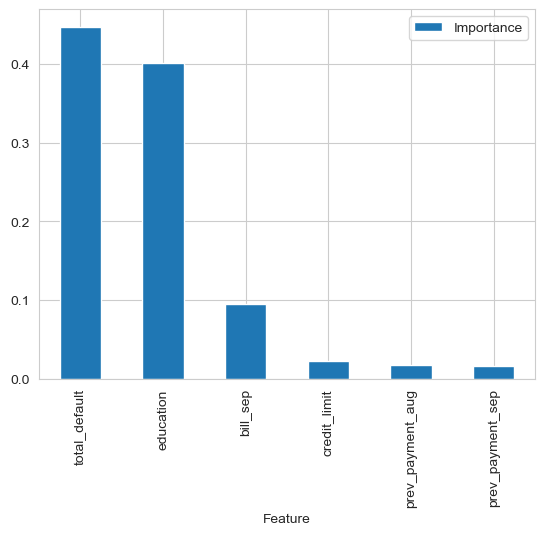

In [204]:
# create DataFrame to display feature importance
df_feature_importance_2 = (pd.DataFrame(data={
    'Feature': X_train.columns[pipeline_clf_2['feat_selection'].get_support()],
    'Importance': pipeline_clf_2['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# re-assign best_features order
best_features_2 = df_feature_importance_2['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance_2['Feature'].to_list()}")

df_feature_importance_2.plot(kind='bar', x='Feature', y='Importance')
plt.show()


These features make somewhat more sense, with `total_default` ranked the highest. Finally, we can evaluate the confusion matrix and classification report:

In [205]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)


In [206]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf_2,
                label_map= ['No Default', 'Default'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                      Actual No Default Actual Default
Prediction No Default             16068           4645
Prediction Default                 2609          14032


---  Classification Report  ---
              precision    recall  f1-score   support

  No Default       0.78      0.86      0.82     18677
     Default       0.84      0.75      0.79     18677

    accuracy                           0.81     37354
   macro avg       0.81      0.81      0.81     37354
weighted avg       0.81      0.81      0.81     37354
 

#### Test Set ####

---  Confusion Matrix  ---
                      Actual No Default Actual Default
Prediction No Default              4009            683
Prediction Default                  678            630


---  Classification Report  ---
              precision    recall  f1-score   support

  No Default       0.85      0.86      0.85      4687
     Default       0.48      0.48      0.48      1313

    accuracy 

## Evaluation and Next Steps

This shows a somewhat improved performance; the model is scoring lower on the train set but higher on the test set than in the first attempt, suggesting that it is better able to generalise to unseen data. However, its performance in classifying the desired metric of Default is still relatively weak, with precision, recall and F1 scores all below 0.5.

At this point, we have a number of options:
* We could attempt further hyperparameter tuning on the current dataset with the current algorithms, `ExtraTreesClassifier` and `RandomForestClassifier`.
* We noted above that applying the SMOTE technique to the dataset could lead to the model overfitting, so we can return to this step and undersample the majority class instead.
* We can look further down our initial list of algorithms from when we tested them all with their default hyperparameters. The next highest two algorithms, both with similar mean scores of 0.76, were `XGBClassifier`	 and `GradientBoostingClassifier`
* We can also consider trying neural network models, since these may be better able to capture complex patterns in the data.

We have already performed hyperparameter tuning on `ExtraTreesClassifier` and `RandomForestClassifier` and achieved improved performance. However, the model's ability to predict default in the test set is still significantly below our success metric of 80% for the F1 score. Further tuning may not lead to sufficient improvements to reach this metric. It seems most appropriate to attempt the other steps first and only return to this as a last resort.

The most sensible ordering of the remaining steps seems to be:

1. Try hyperparameter tuning for `XGBClassifier` and `GradientBoostingClassifier`, since this can be done in the current notebook as an extension of the existing workflow.
2. If this is not successful, move to a new workbook; start from the 'Handle Target Imbalance' step above. Instead of applying SMOTE at this point, use undersampling, then repeat the following steps to train the ML pipeline.
3. Finally, we can also try applying a neural network model. Given the computational resources this is likely to require and that the current cells are already computationally challenging to run for the available processing capacity, it makes sense to keep this separate from the current set of algorithms being considered.

## Hyperparameter optimisation for XGBClassifier and GradientBoostingClassifier

`XGBClassifier` and `GradientBoostingClassifier` are both gradient boosting algorithms that train the model iteratively by combining multiple weak prediction models to create a strong predictive model.

The [XGBoost docs](https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html) include some clear and useful guidelines for hyperparameter tuning, and the [GradientBoostingClassifier docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) also define the numerous parameters that can be tuned for this algorithm.

Since we know that overfitting has previously been a concern, values are chosen to try and prevent this:
XGB gamma:
Low value: 0.0

This means no minimum reduction in loss is required for a split, allowing the model to split even if it leads to a small improvement in the loss function. This can result in more complex models that might be prone to overfitting.
Moderate value: 0.1

A moderate value of 0.1 sets a relatively low threshold for making splits. It allows for some flexibility in splitting the nodes, striking a balance between model complexity and overfitting.
Higher value: 0.3

A higher value of 0.3 imposes a stricter requirement for a reduction in loss, resulting in fewer splits. This can help simplify the model and reduce the risk of overfitting, particularly in cases where the dataset is small or noisy.


In [207]:
models_search_3 = {
    "XGBClassifier": XGBClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
}

params_search_3 = {
    "XGBClassifier":{
      'model__n_estimators': [30, 80, 200],
      'model__max_depth': [None, 3, 15],
      'model__learning_rate': [0.001, 0.01, 0.1],
      'model__gamma': [0, 0.1, 0.3],
      'subsample': [0.5, 0.7, 0.9],
      'colsample_bytree': [0.5, 0.75, 1.0],
      'min_child_weight': [1, 5, 10]
    },
    "GradientBoostingClassifier":{
      'model__n_estimators': [100, 50, 140],
      'model__learning_rate':[0.1, 0.01, 0.001],
      'model__max_depth': [3, 15, None],
      'model__min_samples_split': [2, 25, 50],
      'model__min_samples_leaf': [1, 25, 50],
      'model__max_leaf_nodes': [None, 25, 50]
    },
  }

In [ ]:
detail_search_3 = HyperparameterOptimizationSearch(models=models_search_3, params=params_search_3)
detail_search_3.fit(X_train, y_train,
           scoring =  make_scorer(f1_score),
           n_jobs=-1, cv=5)

---

# Push files to Repo

* In case you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [129]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)


IndentationError: expected an indented block (2852421808.py, line 5)